## Contador de coches autopista mediante opencv (cv2)

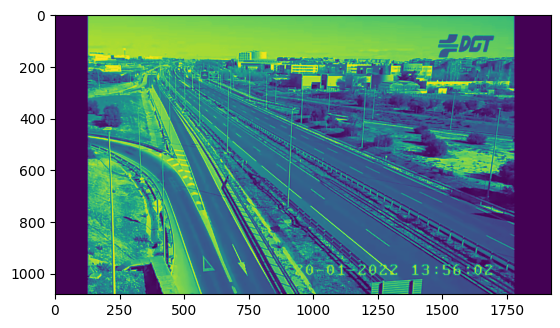

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time


cap = cv2.VideoCapture("tráfico01.mp4")

(grabbed, frame) = cap.read()
frames = []
contador = 1

while grabbed and contador<50:
    (grabbed, frame) = cap.read()
    frames.append(frame)
    contador += 1
cap.release()
background = np.median(frames, axis=0).astype(dtype=np.uint8)
gris = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY) # Convertimos a escala de grises

background_r = cv2.GaussianBlur(gris, (5, 5), 0) #Difuminamos imagen para eliminar ruido
plt.imshow(background_r)

In [2]:
import math

class Rastreador:
    def __init__(self):
        #Guarda los posiciones de los centros junto con su id para saber si ya se ha detectado el coche
        self.centro_puntos = {}
        # Cuenta los objetos
        self.id_count = 1

    def rastreo(self, objetos):
        objetos_id = [] # Aquí se va a almacenar el id con el rectangulo

        # Obtenemos el punto central de los objetos almacenados en objetos
        for rect in objetos:
            x, y, w, h = rect
            cx = (x + x + w)//2
            cy = (y +y +h)//2

            # Comprobamos si el objeto ya ha sido detectado y se encuentra guardado en self.centro_puntos
            obj_det = False
            for id, pt in self.centro_puntos.items():
                dist = math.hypot(cx-pt[0], cy-pt[1]) # Aquí comparamos el centroide del objeto calculado con el almacenado

                # Si ya fue detectado 
                if dist < 70:
                    self.centro_puntos[id] = (cx, cy) # Se actualiza el centroide del id del coche
                    objetos_id.append([x, y, w, h, id]) # Añadimos ese objeto que contiene el centroide y el rectangulo a objetos_id
                    obj_det = True # Este objeto ha sido detectado y almacenado
                    break
            
            # Si es un nuevo objeto le asignamos un nuevo ID 
            if obj_det is False:
                self.centro_puntos[self.id_count] = (cx, cy) # Almacenamos en self.centro_puntos las coordenadas x e y junto con su id
                objetos_id.append([x, y, w, h, self.id_count]) # Agregamos el objeto con su ID
                self.id_count += 1 # Aumentamos el ID (Si no lo hicieramos todos los coches tendrian el mismo id)
        

       
        return objetos_id

In [3]:
# EJERCICIO FINAL
import numpy as np
import cv2
import time
from random import randrange
   
offset = 6
line_height1 = 650
matches = []
contador = 0
index = -1
cars = 0
seguimiento = Rastreador()
 
# Esta función dará las coordenadas del centro del rectángulo

def get_centrolid(x, y, w, h):
   x1 = int(w / 2)
   y1 = int(h / 2)
 
   cx = x + x1
   cy = y + y1

   return cx, cy

 
 
 
cap = cv2.VideoCapture('tráfico01.mp4')
while True:

    #recorremos todos los frames
    (grabbed,frame) = cap.read()
    cap.read()

    gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Convertimos a escala de grises

    resta = cv2.absdiff(gris, background_r) #Hayamos diferencia

    blur = cv2.GaussianBlur(resta, (5, 5), 4) #Difuminamos imagen para eliminar ruido
 
	# Aplicamos un umbral
    umbral = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
 
	# Dilatamos el umbral para tapar agujeros
    umbral = cv2.dilate(umbral, None, iterations=2)

    detecciones = [] # Lista donde vamos a almacenar la información

   # Buscamos los contornos 
    contours, h = cv2.findContours(
    umbral, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # Eliminamos los contornos más pequeños
        if cv2.contourArea(c) < 2000:
            continue
       
       #sacamos las coordenadas de el contorno
        (x, y, w, h) = cv2.boundingRect(c)
       
       #las metemos en la lista de detecciones, para mas tarde darles un id a cada deteccion
        detecciones.append([x, y, w, h])
 
        cv2.line(frame, (400, line_height1), (1450, line_height1), (0, 255, 0), 2) # Dibujamos la línea 
       
        centrolid = get_centrolid(x, y, w, h) #Te da un vector con las coordenadas del centroide
        matches.append(centrolid) # El vector del centroide se añade a matches
        cv2.circle(frame, centrolid, 5, (0, 255, 0), -1) # Dibuja un círculo 
        cx, cy = get_centrolid(x, y, w, h)

        #Contador
        for (x, y) in matches:
            if y < (line_height1+offset) and y > (line_height1-offset): # Establecemos un intervalo, en el que, si el centroide se encuentra dentro de ese intervalo, se contará como un coche
                cv2.line(frame, (0, line_height1), (2000, line_height1), (0, 0, 255), 4) # Dibujamos la línea 
                cars = cars+1
                matches.remove((x, y)) # De esta manera no contaremos dos veces el centroide calculado
    
    # Seguimiento de los objetos
    info_id = seguimiento.rastreo(detecciones)
    for inf in info_id:
        x, y, w, h, id = inf
        cv2.putText(frame, str(id), (x, y-15), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 255), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 3)

    #print(info_id)



 
    cv2.putText(frame, "Total Cars Detected: " + str(cars), (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1,
               (0, 170, 0), 2)
   
    cv2.imshow("Vehicle Detection", frame)
    cv2.imshow("Difference" ,resta) # Diferencia entre el fondo y el frame umbralizada
    if cv2.waitKey(10) == 27:
        break
 
cv2.destroyAllWindows()
cap.release()

KeyboardInterrupt: 